In [2]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [3]:
date = '20220809'
dataNo = 3
scanNo = 3

In [4]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [5]:
param_name ='A0139: LS Phase 1'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[5]
sample3 = unique_param[11]
unit = '(deg)'
flcount = scan_data['Total count @ ROI1 (arb. u.)']

In [6]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat.tiff'))
    update_files = list(Path(path_img).glob('seq*_update.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '165(deg)')

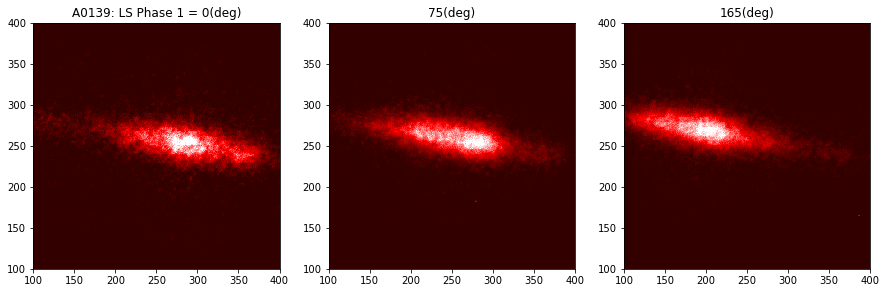

In [7]:
vmin = 50
vmax = 1000
xlim_1 = 100
xlim_2 = 400
ylim_1 = 100
ylim_2 = 400

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name+ " = %.0f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("%.0f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title("%.0f"%(sample3)+unit)

In [8]:
img_ave_by_unique_param = []
for i in range(len(unique_param)):
    img_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            img_temp.append(img_trans_list[j])
    img_ave_by_unique_param.append(np.average(img_temp, axis=0))

In [9]:
change = True
while change:
    change = False
    for i in range(len(unique_param)-1):
        if unique_param[i]>unique_param[i+1]:
            unique_param[i], unique_param[i+1] = unique_param[i+1], unique_param[i]
            img_ave_by_unique_param[i], img_ave_by_unique_param[i+1] = img_ave_by_unique_param[i+1], img_ave_by_unique_param[i]
            change = True

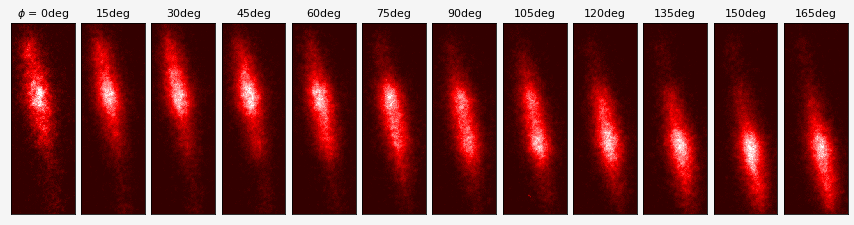

In [29]:
vmin = 50
vmax = 1200
xlim_1 = 210
xlim_2 = 310
ylim_1 = 100
ylim_2 = 400

column_number = 12
row_number = 1

fig, axes = plt.subplots(row_number, column_number, figsize=(15,4), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.1, hspace=0.35)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[j].pcolormesh(np.transpose(img_ave_by_unique_param[column_number*i+j]), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[j].set_aspect('equal')
            axes[j].set_xlim(xlim_1,xlim_2)
            axes[j].set_ylim(ylim_1,ylim_2)
            axes[j].xaxis.set_visible(False)
            axes[j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[j].set_title(r'$\phi$'+ " = %d"%(unique_param[column_number*i+j])+'deg', fontsize=11)
            else:
                axes[j].set_title("%d"%(unique_param[column_number*i+j])+'deg', fontsize=11)

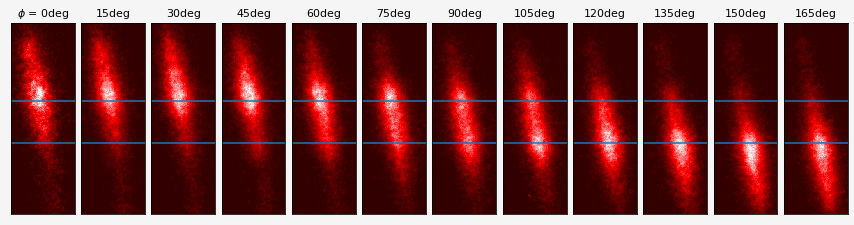

In [30]:
fig, axes = plt.subplots(row_number, column_number, figsize=(15,4), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.1, hspace=0.35)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[j].pcolormesh(np.transpose(img_ave_by_unique_param[column_number*i+j]), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[j].set_aspect('equal')
            axes[j].set_xlim(xlim_1,xlim_2)
            axes[j].set_ylim(ylim_1,ylim_2)
            axes[j].hlines(y=278, xmin=xlim_1, xmax=xlim_2)
            axes[j].hlines(y=211, xmin=xlim_1, xmax=xlim_2)
            axes[j].xaxis.set_visible(False)
            axes[j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[j].set_title(r'$\phi$'+ " = %d"%(unique_param[column_number*i+j])+'deg', fontsize=11)
            else:
                axes[j].set_title("%d"%(unique_param[column_number*i+j])+'deg', fontsize=11)